In [18]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
from smplpytorch.pytorch.smpl_layer import SMPL_Layer
from display_utils import display_model
import pickle
import joblib
import os
import numpy as np
from scipy.interpolate import interp1d
from imu_base import calculate_patch_IMU_signals
import torch
from scipy.spatial.transform import Rotation as R
from imu_noise import add_imu_noise,sharpen_peaks
from inerpolate import upsample_smpl_with_jitter

In [19]:
pkl_file = '/home/lala/Downloads/wham_output 2.pkl'
smpl_data = joblib.load(pkl_file)
print(smpl_data[0].keys())
loaded_data = smpl_data[0]

dict_keys(['pose', 'trans', 'pose_world', 'trans_world', 'betas', 'verts', 'frame_ids'])


In [20]:
# ----------------------------------------------------
# 1) Load original motion data
# ----------------------------------------------------
poses = loaded_data['pose']   # (N, 72)
betas = loaded_data['betas']  # (N, 10)
trans = loaded_data['trans']  # (N, 3)



In [21]:
# ----------------------------------------------------
# 2) Interpolate to high frequency
# ----------------------------------------------------
fps_original = 15
fps_high = 15
dt = 1.0 / fps_high


num_frames = poses.shape[0]
duration = num_frames / fps_original

t_original = np.linspace(0, duration, num_frames)
num_frames_high = int(duration * fps_high)
t_high = np.linspace(0, duration, num_frames_high)

# Interpolate translation
trans_high = np.zeros((num_frames_high, 3))
for d in range(3):
    f = interp1d(t_original, trans[:, d], kind='cubic')
    trans_high[:, d] = f(t_high)

# Interpolate poses (component-wise for simplicity)
poses_high = np.zeros((num_frames_high, poses.shape[1]))
for d in range(poses.shape[1]):
    f = interp1d(t_original, poses[:, d], kind='cubic')
    poses_high[:, d] = f(t_high)


In [22]:
# ----------------------------------------------------
# 3) Setup SMPL layer
# ----------------------------------------------------
smpl_layer = SMPL_Layer(
    center_idx=0,
    gender='neutral',
    model_root='smplpytorch/native/models'
)

cuda = torch.cuda.is_available()
if cuda:
    smpl_layer.cuda()

In [23]:
print(f"Generating high-freq SMPL meshes: {num_frames_high} frames at {fps_high} Hz")

all_verts = []
all_jtr = []

for i in range(num_frames_high):
    pose_params = torch.tensor(poses_high[i:i+1], dtype=torch.float32)
    shape_params = torch.tensor(betas[0:1], dtype=torch.float32)

    if cuda:
        pose_params = pose_params.cuda()
        shape_params = shape_params.cuda()

    with torch.no_grad():
        verts, Jtr = smpl_layer(pose_params, th_betas=shape_params)

    verts[:, :, 1] *= -1  # flip Y if needed
    Jtr[:, :, 1] *= -1

    # SAFE translation addition
    trans_torch = torch.tensor(trans_high[i:i+1], dtype=torch.float32)
    if cuda:
        trans_torch = trans_torch.cuda()

    verts = verts + trans_torch
    jtr = Jtr + trans_torch

    all_verts.append(verts.cpu().numpy())
    all_jtr.append(jtr.cpu().numpy())

all_verts = np.array(all_verts) 
all_jtr = np.array(all_jtr)

print(f"Verts shape: {all_verts.shape}")
print(f"Verts shape: {all_jtr.shape}")


Generating high-freq SMPL meshes: 42 frames at 15 Hz
Verts shape: (42, 1, 6890, 3)
Verts shape: (42, 1, 24, 3)


In [24]:
# ----------------------------------------------------
# 5) IMU cluster list
# ----------------------------------------------------
UTD_lists = {
    'right_wrist': {
        #'verts': [5405, 5430, 5431]
        'verts': [5669, 5705, 5430]
    },
    'right_thigh': {
        'verts': [847, 849, 957]
    }
}

In [25]:
# ----------------------------------------------------
# 6) Make height 1.75
# ----------------------------------------------------

lists = {
    'forehead': [0, 1, 5, 132, 133, 232, 234, 235, 259, 335, 336, 3512, 3513, 3514, 3515, 3517, 3644, 3645, 3646, 3676, 3744, 3745, 3746, 3771],
    'right_leg': [847, 848, 849, 850, 872, 873, 874, 875, 876, 877, 904, 905, 906, 907, 957, 1159, 1365, 1366, 1499, 1500],
    'left_leg': [4333, 4334, 4335, 4336, 4358, 4359, 4360, 4361, 4362, 4363, 4645, 4648, 4711, 4712, 4801, 4802, 4839]
}

forehead_indices = lists['forehead']
right_leg_indices = lists['right_leg']
left_leg_indices = lists['left_leg']

forehead_centroids = np.mean(all_verts[:, 0, forehead_indices], axis=1)
right_leg_centroids = np.mean(all_verts[:, 0, right_leg_indices], axis=1)
left_leg_centroids = np.mean(all_verts[:, 0, left_leg_indices], axis=1)

# Calculate centroid of legs (average of right and left)
leg_centroids = (right_leg_centroids + left_leg_centroids) / 2

# Calculate Euclidean distance between forehead and leg centroids
distances = np.linalg.norm(forehead_centroids - leg_centroids, axis=1)
average_height = np.mean(distances)
scale_factor = 1.75 / average_height

all_verts = np.array(all_verts) * scale_factor
all_jtr = np.array(all_jtr) * scale_factor

In [26]:
from imu_base import calculate_patch_IMU_signals
# ----------------------------------------------------
# 7) Compute & save for each patch IMU
# ----------------------------------------------------
save_dir = "/home/lala/2"
os.makedirs(save_dir, exist_ok=True)

for body_part, config in UTD_lists.items():
    verts = config['verts']

    print(f"Processing PATCH IMU: {body_part}")

    positions, orientations, linear_accel_loc, linear_accel_world, angular_velo = calculate_patch_IMU_signals(
        all_verts,
        verts,
        dt
    )

    file_path = os.path.join(save_dir, f'{body_part}.npz')
    np.savez(file_path,
             positions=positions,
             orientations=orientations,
             global_acceleration=linear_accel_world,
             local_accel=linear_accel_loc,
             angular_velocity=angular_velo)

    print(f"Saved PATCH IMU data: {file_path}")


Processing PATCH IMU: right_wrist
Saved PATCH IMU data: /home/lala/2/right_wrist.npz
Processing PATCH IMU: right_thigh
Saved PATCH IMU data: /home/lala/2/right_thigh.npz


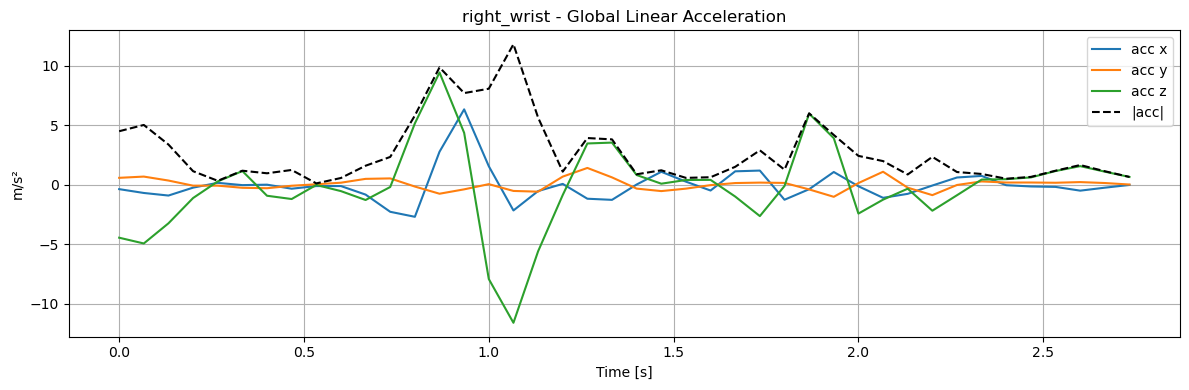

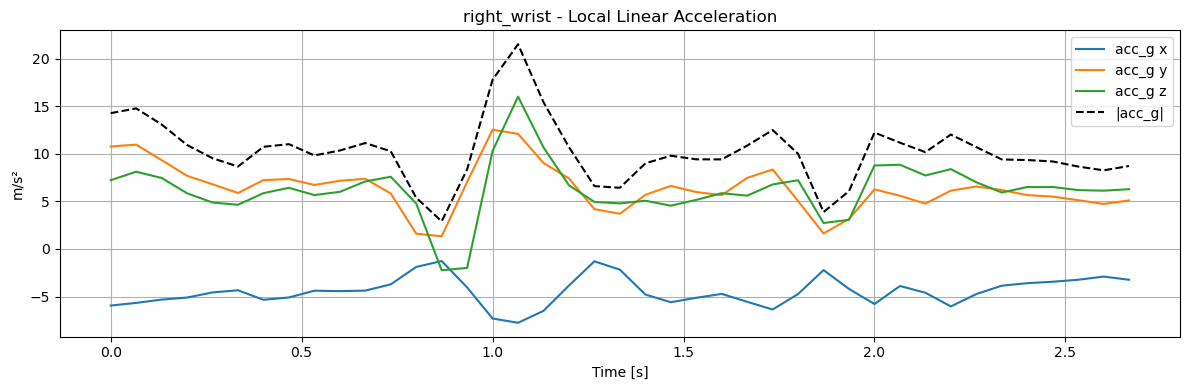

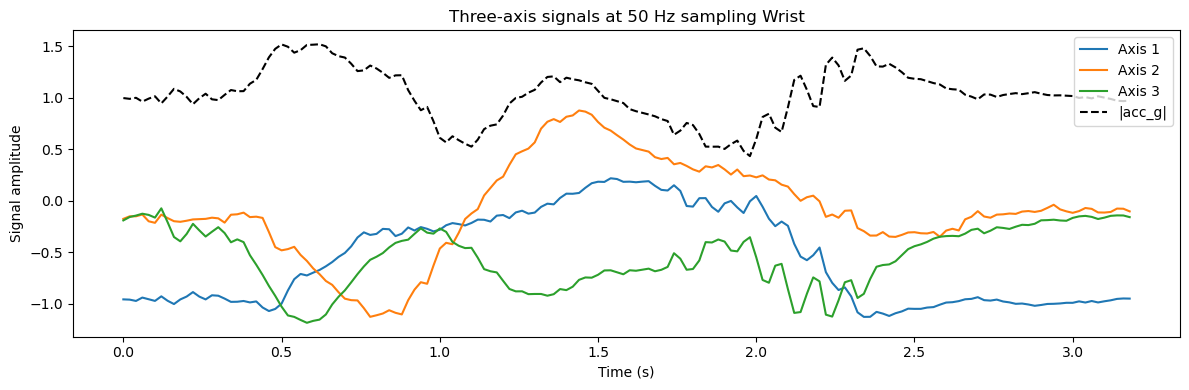

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
save_dir = r"/home/lala/2"
body_part = 'right_wrist'

file_path = os.path.join(save_dir, f'{body_part}.npz')
data = np.load(file_path)

acc = data['global_acceleration']
acc_g = data['local_accel']
ang_vel = data['angular_velocity']

fps = fps_high

# Time for acc
t_acc = np.arange(len(acc)) / fps

# Time for acc_g
t_acc_g = np.arange(len(acc_g)) / fps

# Time for ang_vel
t_ang = np.arange(len(ang_vel)) / fps

# --- Plot global linear acceleration ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Global Linear Acceleration")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_acc, acc[:, i], label=f'acc {axis}')
plt.plot(t_acc, np.linalg.norm(acc, axis=1), 'k--', label='|acc|')
plt.xlabel('Time [s]')
plt.ylabel('m/s²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot local linear acceleration ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Local Linear Acceleration")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_acc_g, acc_g[:, i], label=f'acc_g {axis}')
plt.plot(t_acc_g, np.linalg.norm(acc_g, axis=1), 'k--', label='|acc_g|')
plt.xlabel('Time [s]')
plt.ylabel('m/s²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


import pandas as pd
import scipy.io
 
 
real_inertial_data = scipy.io.loadmat("/home/lala/Downloads/a1_s1_t1_inertial.mat")['d_iner']
 

fs = 50          # sampling frequency in Hz
dt = 1.0 / fs    # time between samples
N = real_inertial_data.shape[0]
 
# build the time vector
t = np.arange(N) * dt
 
plt.figure(figsize=(12, 4))
plt.plot(t, real_inertial_data[:, 0], label='Axis 1')
plt.plot(t, real_inertial_data[:, 1], label='Axis 2')
plt.plot(t, real_inertial_data[:, 2], label='Axis 3')
plt.plot(t, np.linalg.norm(real_inertial_data[:,0:3], axis=1), 'k--', label='|acc_g|')
 
plt.xlabel('Time (s)')
plt.ylabel('Signal amplitude')
plt.title('Three-axis signals at 50 Hz sampling Wrist')
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
angular_velocity_sharp = sharpen_peaks(ang_vel,power_range=(1.1, 1.5),mix=0.8)
acc_sharp = sharpen_peaks(acc_g, power_range=(1.01, 1.05), mix=0.4)

acc_realistic = add_imu_noise(acc_sharp, fs=fps_high, noise_type='full')
gyro_realistic = add_imu_noise(angular_velocity_sharp, fs=fps_high, noise_type='full')

# --- Plot local linear acceleration ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Local Linear Acceleration")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_acc_g, acc_realistic[:, i], label=f'acc_g {axis}')
plt.plot(t_acc_g, np.linalg.norm(acc_realistic, axis=1), 'k--', label='|acc_g|')
plt.xlabel('Time [s]')
plt.ylabel('m/s²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot angular velocity ---
plt.figure(figsize=(12, 4))
plt.title(f"{body_part} - Angular Velocity")
for i, axis in enumerate(['x', 'y', 'z']):
    plt.plot(t_ang, gyro_realistic[:, i], label=f'ω {axis}')
plt.plot(t_ang, np.linalg.norm(gyro_realistic, axis=1), 'k--', label='|ω|')
plt.xlabel('Time [s]')
plt.ylabel('rad/s')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: Digital filter critical frequencies must be 0 < Wn < 1

In [29]:
new_jtr = np.squeeze(all_jtr, axis=1)


(42, 24, 3)
(41, 3)


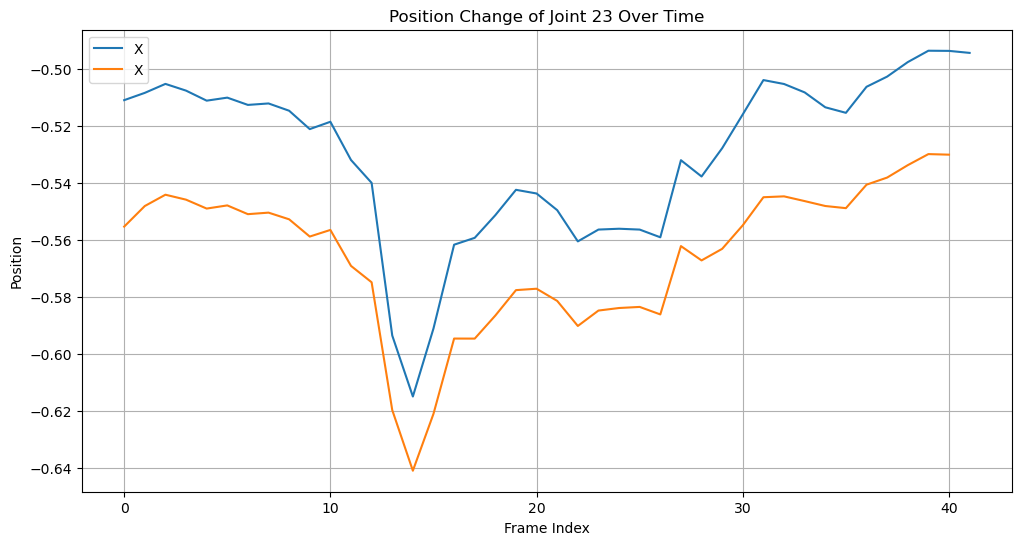

In [30]:
print(new_jtr.shape)
# Select joint number 23 (index 23 in zero-based indexing)
joint_index = 23
joint_23_positions = new_jtr[:, joint_index, :]  # shape: [280, 3]
pose = data['positions']
print(pose.shape)


# Plot X, Y, Z over time
plt.figure(figsize=(12, 6))
plt.plot(joint_23_positions[:, 0], label='X')
#plt.plot(joint_23_positions[:, 1], label='Y')
#plt.plot(joint_23_positions[:, 2], label='Z')
plt.plot(pose[:, 0], label='X')
#plt.plot(pose[:, 1], label='Y')
#plt.plot(pose[:, 2], label='Z')

plt.title('Position Change of Joint 23 Over Time')
plt.xlabel('Frame Index')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.show()


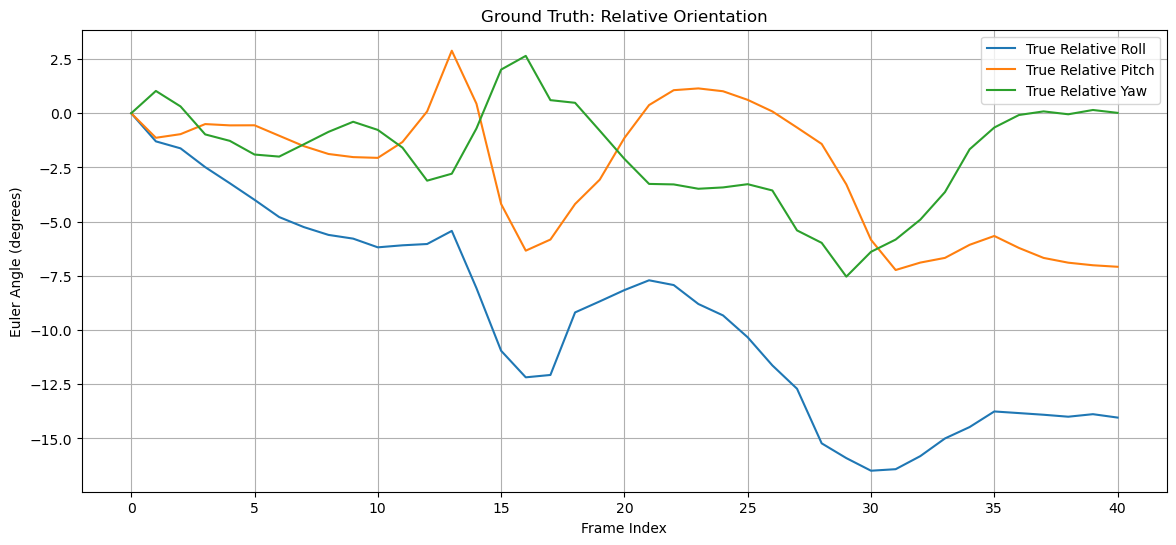

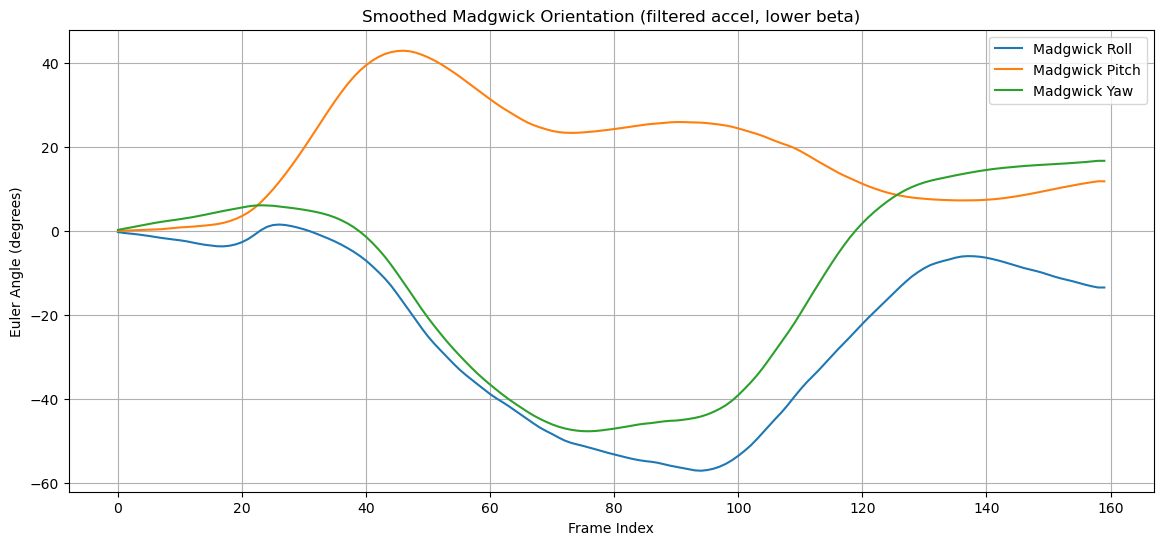

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# === Load your quaternions ===
ore = data['orientations']  # shape (N, 4)

# === Normalize ===
ore = ore / np.linalg.norm(ore, axis=1, keepdims=True)

# === Compute relative rotation ===
rot = R.from_quat(ore)
rot0_inv = rot[0].inv()
rot_rel = rot0_inv * rot  # (N,)

# === Convert to Euler ===
eulers_rel = rot_rel.as_euler('xyz', degrees=True)

# === Plot ===
plt.figure(figsize=(14, 6))
plt.plot(eulers_rel[:, 0], label='True Relative Roll')
plt.plot(eulers_rel[:, 1], label='True Relative Pitch')
plt.plot(eulers_rel[:, 2], label='True Relative Yaw')
plt.title('Ground Truth: Relative Orientation')
plt.xlabel('Frame Index')
plt.ylabel('Euler Angle (degrees)')
plt.legend()
plt.grid(True)
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from ahrs.filters import Madgwick
from scipy.signal import butter, filtfilt
from scipy.spatial.transform import Rotation as R

# === Load ===
gyro = real_inertial_data[:, 3:6]
accel = real_inertial_data[:, 0:3]

fs = 50.0
dt = 1.0 / fs
N = gyro.shape[0]

# ✅ Convert gyro to rad/s
gyro = np.deg2rad(gyro)  # Only if in deg/s!

# ✅ Filter gyro bias
gyro = gyro - np.mean(gyro, axis=0)

# ✅ Low-pass filter the accelerometer
def lowpass(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    norm = cutoff / nyq
    b, a = butter(order, norm, btype='low')
    return filtfilt(b, a, data, axis=0)

accel_filt = lowpass(accel, cutoff=5.0, fs=fs)

# ✅ Normalize accel to unit g for stability
accel_filt = accel_filt / np.linalg.norm(accel_filt, axis=1, keepdims=True)

# ✅ Use a smaller beta for smoother output
madgwick = Madgwick(sampleperiod=dt, beta=0.02)  # Try 0.02–0.05

q_madgwick = np.zeros((N, 4))
q_madgwick[0] = [1, 0, 0, 0]

for t in range(1, N):
    q_madgwick[t] = madgwick.updateIMU(q=q_madgwick[t-1], gyr=gyro[t], acc=accel_filt[t])

# Convert to scipy convention
q_madgwick_scipy = np.column_stack((q_madgwick[:, 1], q_madgwick[:, 2], q_madgwick[:, 3], q_madgwick[:, 0]))

r_madgwick = R.from_quat(q_madgwick_scipy)
eulers_madgwick = r_madgwick.as_euler('xyz', degrees=True)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(eulers_madgwick[:, 0], label='Madgwick Roll')
plt.plot(eulers_madgwick[:, 1], label='Madgwick Pitch')
plt.plot(eulers_madgwick[:, 2], label='Madgwick Yaw')
plt.title('Smoothed Madgwick Orientation (filtered accel, lower beta)')
plt.xlabel('Frame Index')
plt.ylabel('Euler Angle (degrees)')
plt.legend()
plt.grid(True)
plt.show()

